## Fast tokenizers’ special powers

⚠️ When tokenizing a single sentence, you won’t always see a difference in speed between the slow and fast versions of the same tokenizer. In fact, the fast version might actually be slower! It’s only when tokenizing lots of texts in parallel at the same time that you will be able to clearly see the difference.

The output of a tokenizer isn’t a simple Python dictionary; what we get is actually a special BatchEncoding object. It’s a subclass of a dictionary (which is why we were able to index into that result without any problem before), but with additional methods that are mostly used by fast tokenizers.

Besides their parallelization capabilities, the key functionality of fast tokenizers is that they always keep track of the original span of texts the final tokens come from — a feature we call offset mapping. This in turn unlocks features like mapping each word to the tokens it generated or mapping each character of the original text to the token it’s inside, and vice versa.

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

<class 'transformers.tokenization_utils_base.BatchEncoding'>


Since the AutoTokenizer class picks a fast tokenizer by default, we can use the additional methods this BatchEncoding object provides. We have two ways to check if our tokenizer is a fast or a slow one. We can either check the attribute is_fast of the tokenizer:

In [3]:
print(tokenizer.is_fast)

# or check the same attribute of our encoding

print(encoding.is_fast)

True
True


Let’s see what a fast tokenizer enables us to do. First, we can access the tokens without having to convert the IDs back to tokens:

In [4]:
encoding.tokens()


['[CLS]',
 'My',
 'name',
 'is',
 'S',
 '##yl',
 '##va',
 '##in',
 'and',
 'I',
 'work',
 'at',
 'Hu',
 '##gging',
 'Face',
 'in',
 'Brooklyn',
 '.',
 '[SEP]']

In this case the token at index 5 is ##yl, which is part of the word “Sylvain” in the original sentence. We can also use the word_ids() method to get the index of the word each token comes from:

In [5]:
encoding.word_ids()


[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]

We can see that the tokenizer’s special tokens [CLS] and [SEP] are mapped to None, and then each token is mapped to the word it originates from. This is especially useful to determine if a token is at the start of a word or if two tokens are in the same word. We could rely on the ## prefix for that, but it only works for BERT-like tokenizers; this method works for any type of tokenizer as long as it’s a fast one. In the next chapter, we’ll see how we can use this capability to apply the labels we have for each word properly to the tokens in tasks like named entity recognition (NER) and part-of-speech (POS) tagging. We can also use it to mask all the tokens coming from the same word in masked language modeling (a technique called whole word masking).

Similarly, there is a sentence_ids() method that we can use to map a token to the sentence it came from (though in this case, the token_type_ids returned by the tokenizer can give us the same information).

Lastly, we can map any word or token to characters in the original text, and vice versa, via the word_to_chars() or token_to_chars() and char_to_word() or char_to_token() methods. For instance, the word_ids() method told us that ##yl is part of the word at index 3, but which word is it in the sentence? We can find out like this:

In [6]:
start, end = encoding.word_to_chars(3)
example[start:end]

'Sylvain'

As we mentioned previously, this is all powered by the fact the fast tokenizer keeps track of the span of text each token comes from in a list of offsets. To illustrate their use, next we’ll show you how to replicate the results of the token-classification pipeline manually.

Inside the token-classification pipeline

In Chapter 1 we got our first taste of applying NER — where the task is to identify which parts of the text correspond to entities like persons, locations, or organizations — with the 🤗 Transformers pipeline() function. Then, in Chapter 2, we saw how a pipeline groups together the three stages necessary to get the predictions from a raw text: tokenization, passing the inputs through the model, and post-processing. The first two steps in the token-classification pipeline are the same as in any other pipeline, but the post-processing is a little more complex — let’s see how!

Getting the base results with the pipeline

First, let’s grab a token classification pipeline so we can get some results to compare manually. The model used by default is dbmdz/bert-large-cased-finetuned-conll03-english; it performs NER on sentences:

In [7]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\icarl\anaconda3\envs\hf-course\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\icarl\anaconda3\envs\hf-course\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\icarl\.cache\huggingface\hub\models--dbmdz--bert-large-cased-finetuned-conll03-english. Caching files will still work but in a degraded version that might require more

[{'entity': 'I-PER',
  'score': 0.99938285,
  'index': 4,
  'word': 'S',
  'start': 11,
  'end': 12},
 {'entity': 'I-PER',
  'score': 0.99815494,
  'index': 5,
  'word': '##yl',
  'start': 12,
  'end': 14},
 {'entity': 'I-PER',
  'score': 0.99590707,
  'index': 6,
  'word': '##va',
  'start': 14,
  'end': 16},
 {'entity': 'I-PER',
  'score': 0.99923277,
  'index': 7,
  'word': '##in',
  'start': 16,
  'end': 18},
 {'entity': 'I-ORG',
  'score': 0.9738931,
  'index': 12,
  'word': 'Hu',
  'start': 33,
  'end': 35},
 {'entity': 'I-ORG',
  'score': 0.976115,
  'index': 13,
  'word': '##gging',
  'start': 35,
  'end': 40},
 {'entity': 'I-ORG',
  'score': 0.9887976,
  'index': 14,
  'word': 'Face',
  'start': 41,
  'end': 45},
 {'entity': 'I-LOC',
  'score': 0.9932106,
  'index': 16,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

The model properly identified each token generated by “Sylvain” as a person, each token generated by “Hugging Face” as an organization, and the token “Brooklyn” as a location. We can also ask the pipeline to group together the tokens that correspond to the same entity:

In [8]:
from transformers import pipeline

token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\icarl\anaconda3\envs\hf-course\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a

[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

The aggregation_strategy picked will change the scores computed for each grouped entity. With "simple" the score is just the mean of the scores of each token in the given entity: for instance, the score of “Sylvain” is the mean of the scores we saw in the previous example for the tokens S, ##yl, ##va, and ##in. Other strategies available are:

- "first", where the score of each entity is the score of the first token of that entity (so for “Sylvain” it would be 0.993828, the score of the token S)

- "max", where the score of each entity is the maximum score of the tokens in that entity (so for “Hugging Face” it would be 0.98879766, the score of “Face”)

- "average", where the score of each entity is the average of the scores of the words composing that entity (so for “Sylvain” there would be no difference from the "simple" strategy, but “Hugging Face” would have a score of 0.9819, the average of the scores for “Hugging”, 0.975, and “Face”, 0.98879)

Now let’s see how to obtain these results without using the pipeline() function!

From inputs to predictions

First we need to tokenize our input and pass it through the model. This is done exactly as in Chapter 2; we instantiate the tokenizer and the model using the AutoXxx classes and then use them on our example:

In [9]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Since we’re using AutoModelForTokenClassification here, we get one set of logits for each token in the input sequence:

print(inputs["input_ids"].shape)
print(outputs.logits.shape)

torch.Size([1, 19])
torch.Size([1, 19, 9])


In [11]:
# we use a softmax function to convert those logits to probabilities, and we take the argmax to get predictions (note that we can take the argmax on the logits because the softmax does not change the order):

import torch

probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
print(predictions)

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]


The model.config.id2label attribute contains the mapping of indexes to labels that we can use to make sense of the predictions:

In [12]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

As we saw earlier, there are 9 labels: O is the label for the tokens that are not in any named entity (it stands for “outside”), and we then have two labels for each type of entity (miscellaneous, person, organization, and location). The label B-XXX indicates the token is at the beginning of an entity XXX and the label I-XXX indicates the token is inside the entity XXX. For instance, in the current example we would expect our model to classify the token S as B-PER (beginning of a person entity) and the tokens ##yl, ##va and ##in as I-PER (inside a person entity).

You might think the model was wrong in this case as it gave the label I-PER to all four of these tokens, but that’s not entirely true. There are actually two formats for those B- and I- labels: IOB1 and IOB2. The IOB2 format (in pink below), is the one we introduced whereas in the IOB1 format (in blue), the labels beginning with B- are only ever used to separate two adjacent entities of the same type. The model we are using was fine-tuned on a dataset using that format, which is why it assigns the label I-PER to the S token.

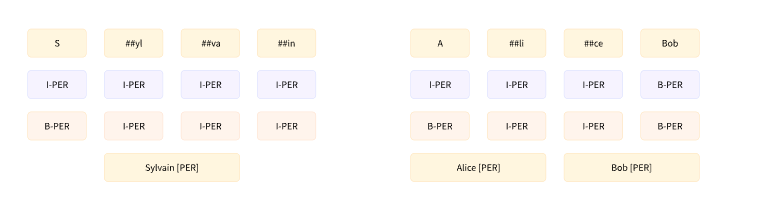

With this map, we are ready to reproduce (almost entirely) the results of the first pipeline — we can just grab the score and label of each token that was not classified as O:

In [13]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]}
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S'}, {'entity': 'I-PER', 'score': 0.9981549382209778, 'word': '##yl'}, {'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va'}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in'}, {'entity': 'I-ORG', 'score': 0.9738931059837341, 'word': 'Hu'}, {'entity': 'I-ORG', 'score': 0.9761149883270264, 'word': '##gging'}, {'entity': 'I-ORG', 'score': 0.9887976050376892, 'word': 'Face'}, {'entity': 'I-LOC', 'score': 0.9932106137275696, 'word': 'Brooklyn'}]


This is very similar to what we had before, with one exception: the pipeline also gave us information about the start and end of each entity in the original sentence. This is where our offset mapping will come into play. To get the offsets, we just have to set return_offsets_mapping=True when we apply the tokenizer to our inputs:

In [14]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]

[(0, 0),
 (0, 2),
 (3, 7),
 (8, 10),
 (11, 12),
 (12, 14),
 (14, 16),
 (16, 18),
 (19, 22),
 (23, 24),
 (25, 29),
 (30, 32),
 (33, 35),
 (35, 40),
 (41, 45),
 (46, 48),
 (49, 57),
 (57, 58),
 (0, 0)]

Each tuple is the span of text corresponding to each token, where (0, 0) is reserved for the special tokens. We saw before that the token at index 5 is ##yl, which has (12, 14) as offsets here. If we grab the corresponding slice in our example:

In [15]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        start, end = offsets[idx]
        results.append(
            {
                "entity": label,
                "score": probabilities[idx][pred],
                "word": tokens[idx],
                "start": start,
                "end": end,
            }
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S', 'start': 11, 'end': 12}, {'entity': 'I-PER', 'score': 0.9981549382209778, 'word': '##yl', 'start': 12, 'end': 14}, {'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va', 'start': 14, 'end': 16}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in', 'start': 16, 'end': 18}, {'entity': 'I-ORG', 'score': 0.9738931059837341, 'word': 'Hu', 'start': 33, 'end': 35}, {'entity': 'I-ORG', 'score': 0.9761149883270264, 'word': '##gging', 'start': 35, 'end': 40}, {'entity': 'I-ORG', 'score': 0.9887976050376892, 'word': 'Face', 'start': 41, 'end': 45}, {'entity': 'I-LOC', 'score': 0.9932106137275696, 'word': 'Brooklyn', 'start': 49, 'end': 57}]


Grouping entities

Using the offsets to determine the start and end keys for each entity is handy, but that information isn’t strictly necessary. When we want to group the entities together, however, the offsets will save us a lot of messy code. For example, if we wanted to group together the tokens Hu, ##gging, and Face, we could make special rules that say the first two should be attached while removing the ##, and the Face should be added with a space since it does not begin with ## — but that would only work for this particular type of tokenizer. We would have to write another set of rules for a SentencePiece or a Byte-Pair-Encoding tokenizer (discussed later in this chapter).

With the offsets, all that custom code goes away: we just can take the span in the original text that begins with the first token and ends with the last token. So, in the case of the tokens Hu, ##gging, and Face, we should start at character 33 (the beginning of Hu) and end before character 45 (the end of Face):

To write the code that post-processes the predictions while grouping entities, we will group together entities that are consecutive and labeled with I-XXX, except for the first one, which can be labeled as B-XXX or I-XXX (so, we stop grouping an entity when we get a O, a new type of entity, or a B-XXX that tells us an entity of the same type is starting):

In [16]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):
    pred = predictions[idx]
    label = model.config.id2label[pred]
    if label != "O":
        # Remove the B- or I-
        label = label[2:]
        start, _ = offsets[idx]

        # Grab all the tokens labeled with I-label
        all_scores = []
        while (
            idx < len(predictions)
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):
            all_scores.append(probabilities[idx][pred])
            _, end = offsets[idx]
            idx += 1

        # The score is the mean of all the scores of the tokens in that grouped entity
        score = np.mean(all_scores).item()
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

print(results)

[{'entity_group': 'PER', 'score': 0.9981694370508194, 'word': 'Sylvain', 'start': 11, 'end': 18}, {'entity_group': 'ORG', 'score': 0.9796018997828165, 'word': 'Hugging Face', 'start': 33, 'end': 45}, {'entity_group': 'LOC', 'score': 0.9932106137275696, 'word': 'Brooklyn', 'start': 49, 'end': 57}]
